**Initialise**

In [1]:
# Hi Chris, I implemented R2D1 below but did not have enough to to see if it converges (looked like it was learning however),
# a

# No code was used from other sources, however some implementations were used to help.

# Implementation log:
# Utilized output display instead of RAM, using CNN to extract useful features
# Implemented a priority replay buffer with importance sampling https://arxiv.org/pdf/1511.05952.pdf, 
# and used https://github.com/higgsfield/RL-Adventure for code ideas.
# Converting env states to greyscale, squashing to 84x84 and replacing color channels with 
# last 3/4 greyscale frames for POMDP info.
# Implemented DDQN utilizing target network.
# Implemented Dueling architecture for states that don't have strong action choices.
# Implemented n_step learning.
# Implemented non distributed R2D2 (R2D1), some code ideas from https://github.com/google-research/seed_rl, 
# and https://github.com/neka-nat/distributed_rl/blob/master/distributed_rl

# imports
import gym
from IPython.display import clear_output
import collections
from collections import deque
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import os

# hyperparameters
learning_rate = 1e-4
gamma         = 0.997
buffer_limit  = 8000
n_steps = 5 # N step td learning
seq_train_len = 80 # Sequences for LSTM training
seq_burn = 20 # Burn in period
seq_ovlp = 40 # overlap between sequences (< seq_train_len)
seq_len = seq_burn + seq_train_len + n_steps #n_steps as we use the sequences to compute target q
env_name = "Gravitar-v0"
rew_scale = 0.01 if env_name == "Gravitar-v0" else 1

batch_size    = 64
video_every   = 25
print_every   = 5

gam_vals = [(gamma ** x) for x in range(n_steps + 1)] # Precalc gamma vals for small speedup

dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class RecPriorityReplayBuffer(): # Select samples based on TD, I treat sequences almost the exact same as normal samples
    def __init__(self, max_size, alpha = 1):
      self.alpha = alpha
      self.beta = 0.5
      self.max_size = max_size
      self.buffer = [] # Stored as (buffer_size, seq_len, (state, action, reward, done))
      self.index = 0
      self.priorities = np.zeros(max_size)
      self.max_prio = 1.0 # To assign new elements this maximum priority
    
    def put(self, transition):
      if len(self.buffer) >= self.max_size:
        self.buffer[self.index] = transition
      else: # Append if not reached max size
        self.buffer.append(transition)
        
      self.priorities[self.index] = self.max_prio
      self.index = (self.index + 1) % self.max_size
    
    def sample(self, n): # in:  batch size, out: seq (time, batches, (s,a,r,d)), weights, indices
      if len(self.buffer) >= self.max_size:
        selPris = self.priorities
      else:
        selPris = self.priorities[:self.index]

      probs = selPris #** self.alpha # This gon be slow, let's keep it off for now
      probs = probs / probs.sum()
      indices = np.random.choice(len(self.buffer), n, p=probs)
      # Compensation for non uniform sampling to enforce proper convergence
      ISWeights = (len(self.buffer) * probs[indices]) ** -self.beta # (n, 1)
      ISWeights = ISWeights / ISWeights.max() 
      seq_batch = []
      # NTS: Look for smarter way to do this, very slow
      # Turn sequences into seq_len, batch_size order list
      for t in range(seq_len):
        s_lst, a_lst, r_lst, done_mask_lst = [], [], [], []
        for i in indices:
          s, a, r, done_mask = self.buffer[i][t]
          s_lst.append(np.array(s)) # convert state to array (lazy frames)
          a_lst.append([a])
          r_lst.append([r])
          done_mask_lst.append([done_mask])
        seq_batch.append([torch.tensor(s_lst, dtype=torch.float, device=dev), torch.tensor(a_lst, device=dev), \
                          torch.tensor(r_lst, device=dev), torch.tensor(done_mask_lst, device=dev)])

      return seq_batch, torch.tensor(ISWeights, device=dev), torch.tensor(indices, device=dev)
    
    def updatePriorities(self, indices, tdErrors):
      for c, i in enumerate(indices):
        self.priorities[i] = tdErrors[c]
        self.max_prio = max(tdErrors[c], self.max_prio)

    def size(self):
        return len(self.buffer)

In [3]:
class QNetwork(nn.Module): # Dueling network architecture NTS: noisy networks ?? distributional ??
    def __init__(self):
        super(QNetwork, self).__init__()
        # Feature extractor
        self.conv1 = nn.Conv2d(4, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.latFc = nn.Linear(7 * 7 * 32, 512)

        # LSTM:
        self.recMem = nn.LSTMCell(input_size = 512 + env.action_space.n, hidden_size = 512) # NTS: How does this and neural episodic control interact?
        self.hV = torch.zeros(batch_size, 512, device=dev) # Hidden state vector
        self.cV = torch.zeros(batch_size, 512, device=dev) # Cell state vector

        # Dueling DQN
        self.advNet = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n), # For estimating A(S, A) = Q(S,A) - V(A), maybe restrict to fewer actions for more effective e-greedy
          ) 
        self.valNet = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1), # For estimating A(S, A) = Q(S,A) - V(A), maybe restrict to five actions for slightly faster convergence
          )
    
    def setMem(self, nX, nC):
      self.hV = nX
      self.cV = nC

    def getMem(self):
      return self.hV, self.cV
    
    def zeroMem(self, hid_size = batch_size):
      self.hV = torch.zeros(hid_size, 512, device=dev)
      self.cV = torch.zeros(hid_size, 512, device=dev)

    def forward(self, x, prev_actions): # We only iterate through the lstm one iter at a time, storing the hidden and cell state
      pA = torch.zeros(x.shape[0], env.action_space.n, device=dev)
      pA = pA.scatter(1, prev_actions.long(), 1) # One hot encoding of previous actions, for lstm
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = x.reshape(x.size(0),-1)
      x = F.relu(self.latFc(x))
      # Input output from conv net, prev action. Paper also uses previous reward, which is ommitted here.
      self.hV, self.cV = self.recMem(torch.cat((x, pA), dim=1), (self.hV, self.cV))
      Adv = self.advNet(self.hV)
      Val = self.valNet(self.hV)
      QVal = Val + Adv - torch.mean(Adv, dim=1, keepdims=True) # Some sources appear to average over entire batches, this would surely totally destroy the semantics (and prevents learning)
      return QVal
      
    def sample_action(self, obs, epsilon, last_act):
        coin = random.random()
        if coin < epsilon:
          return random.randint(0, env.action_space.n - 1)
        else:
          out = self.forward(obs, last_act)
          return out.argmax().item()



In [4]:
# Train over each sequence, then backprop sum of td errors
def train(q, q_target, memory, optimizer, losses):
  for i in range(1):
    seq, weights, indices  = memory.sample(batch_size)
    last_act = torch.zeros((batch_size, 1), device=dev)

    q.zeroMem()
    q_target.zeroMem()

    # Burn in, lets lstm 'warm up'
    with torch.no_grad():
      for t in range(0, seq_burn):
        state, action, reward, done = seq[t]
        q(state, last_act)
        q_target(seq[t+n_steps][0], seq[t+n_steps - 1][1]) # Burn in target net
        last_act = action

    td_errors = []
    for t in range(seq_burn, seq_len - n_steps):
      state, action, reward, done = seq[t]
      # TD estimate of action using bootstrapping with q_target & DDQN
      with torch.no_grad():
        final_state = seq[t+n_steps][0] # future bootstrap state
        fin_pre_act = seq[t+n_steps-1][1]
        q_next_action = q(final_state, fin_pre_act) # (32, 6)
        q_next_max_action = torch.argmax(q_next_action, dim=1, keepdim=True) # Select best action for next state based on qnetwork (32, 1)
        target_q_next = q_target(final_state, fin_pre_act).gather(1, q_next_max_action.long()) # Calculate target based off target network using action from q network (32, 1)
        target = reward + gam_vals[n_steps] * target_q_next * done_mask # (32, 1)

      # Calculate value of action
      q_preds = q(state, last_act) # Q values of current state (32, 6) 
      q_action = q_preds.gather(1,action) # Select Q value based on off policy E-greedy we followed (32, 1)

      # TD Error, huber loss (32, 1)
      loss = F.smooth_l1_loss(q_action, target, reduction = 'none') #(batch_size, 1)
      td_errors.append(loss)

      last_act = action
    
    td_errors = torch.stack(td_errors) # (seq_train_len, batch_size, 1)
    tot_loss = td_errors.sum(dim=0)  * weights.unsqueeze(1) # (batch_size) Importance weighting
    tot_loss = tot_loss.mean()
    optimizer.zero_grad()
    tot_loss.backward()
    optimizer.step()

    priorities = 0.9 * td_errors.max(dim=0)[0] + (1-0.9) * td_errors.mean(dim=0) # (batch_size)
    memory.updatePriorities(indices, priorities.squeeze(1).cpu().detach().numpy())

    losses.append(tot_loss)

**Train**

← You can download the videos from the videos folder in the files on the left

marking, episode: 0, score: 2.5, mean_score: 2.50, std_score: 0.00


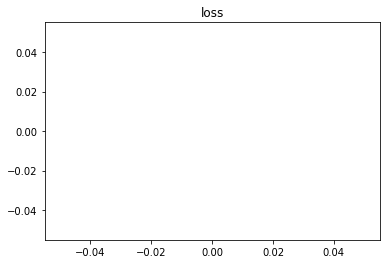

episode: 5, score: 0.0, best score: 3.5, epsilon: 1.00


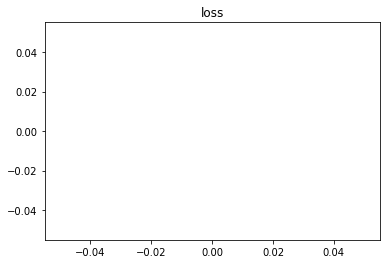

episode: 10, score: 1.0, best score: 3.5, epsilon: 0.99


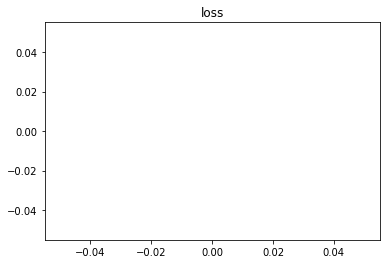

episode: 15, score: 0.0, best score: 8.0, epsilon: 0.99


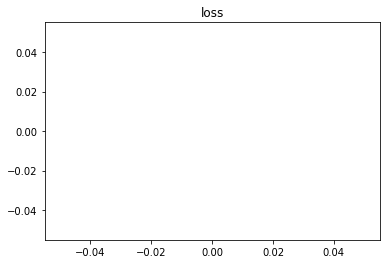

episode: 20, score: 0.0, best score: 8.0, epsilon: 0.99


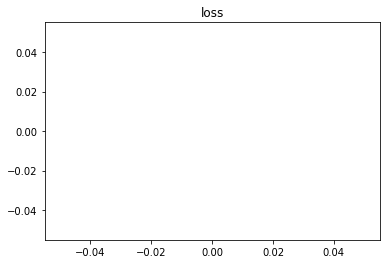

episode: 25, score: 2.5, best score: 8.0, epsilon: 0.99


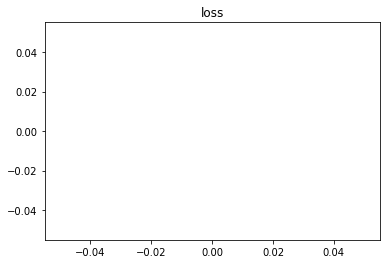

episode: 30, score: 4.0, best score: 8.0, epsilon: 0.98


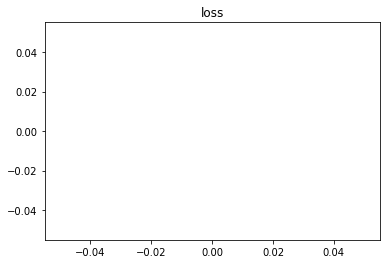

episode: 35, score: 1.0, best score: 8.0, epsilon: 0.98


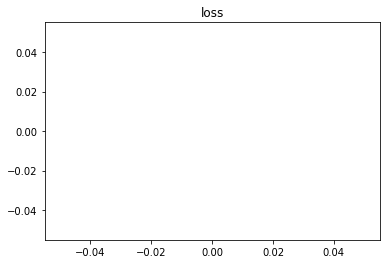

episode: 40, score: 3.5, best score: 9.5, epsilon: 0.98


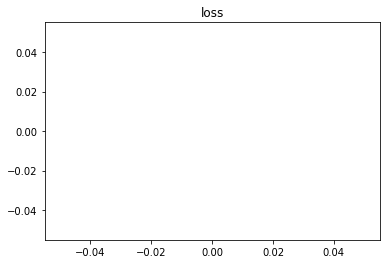

episode: 45, score: 1.0, best score: 9.5, epsilon: 0.98


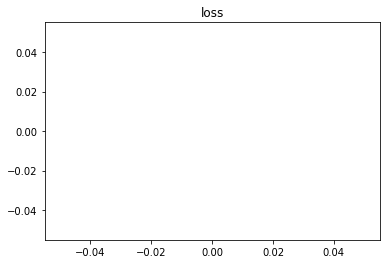

episode: 50, score: 0.0, best score: 9.5, epsilon: 0.97


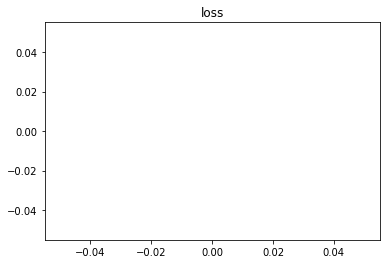

episode: 55, score: 3.5, best score: 9.5, epsilon: 0.97


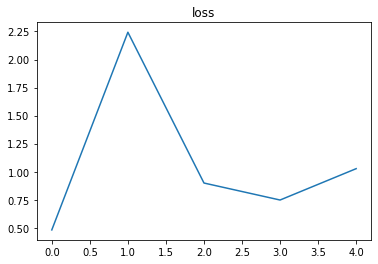

episode: 60, score: 1.0, best score: 9.5, epsilon: 0.97


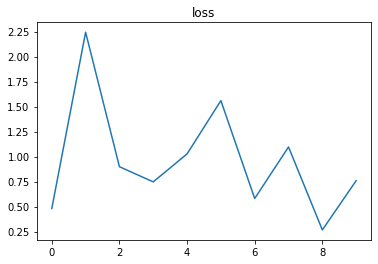

episode: 65, score: 1.0, best score: 9.5, epsilon: 0.97


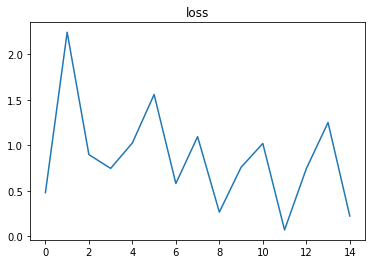

episode: 70, score: 0.0, best score: 9.5, epsilon: 0.96


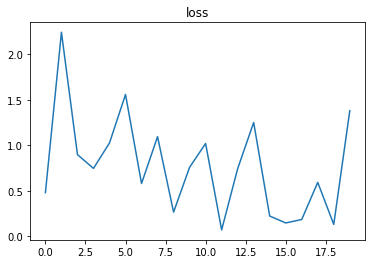

episode: 75, score: 2.5, best score: 9.5, epsilon: 0.96


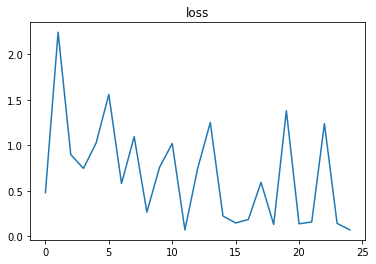

episode: 80, score: 1.0, best score: 9.5, epsilon: 0.96


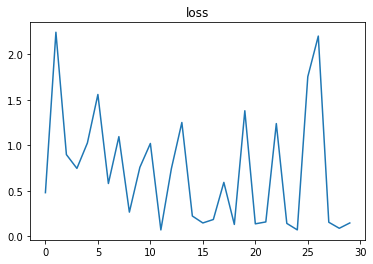

episode: 85, score: 4.5, best score: 9.5, epsilon: 0.96


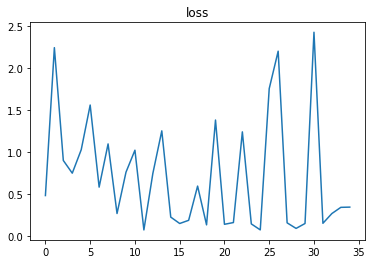

episode: 90, score: 2.5, best score: 9.5, epsilon: 0.95


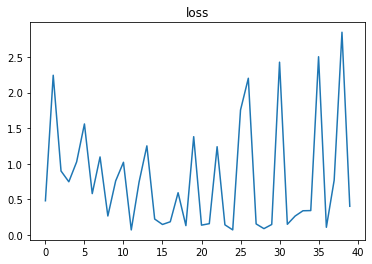

episode: 95, score: 3.5, best score: 9.5, epsilon: 0.95
marking, episode: 100, score: 1.0, mean_score: 1.86, std_score: 1.83


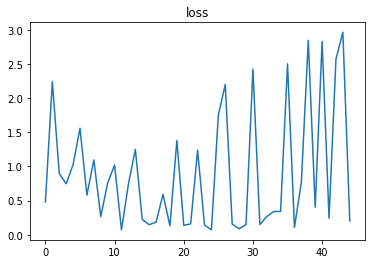

episode: 100, score: 1.0, best score: 9.5, epsilon: 0.95


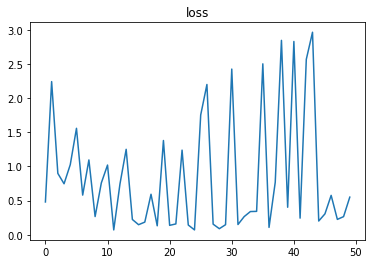

episode: 105, score: 0.0, best score: 9.5, epsilon: 0.95


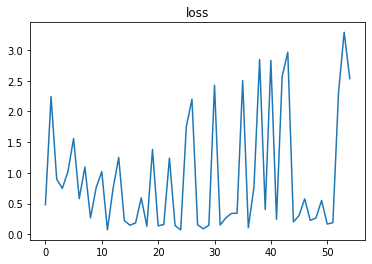

episode: 110, score: 0.0, best score: 9.5, epsilon: 0.94


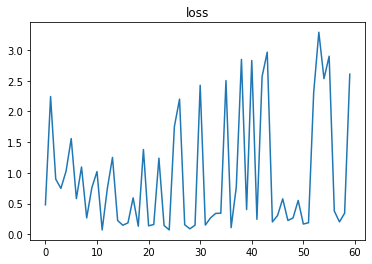

episode: 115, score: 1.0, best score: 9.5, epsilon: 0.94


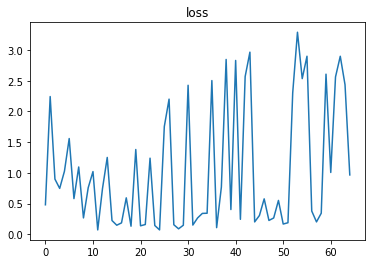

episode: 120, score: 2.5, best score: 9.5, epsilon: 0.94


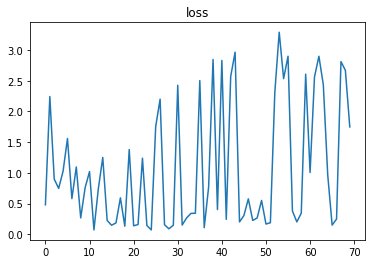

episode: 125, score: 2.5, best score: 9.5, epsilon: 0.94


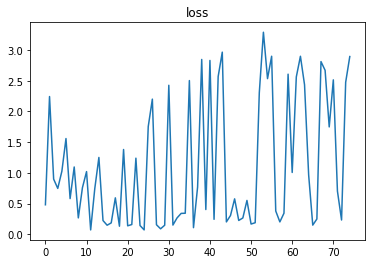

episode: 130, score: 0.0, best score: 9.5, epsilon: 0.94


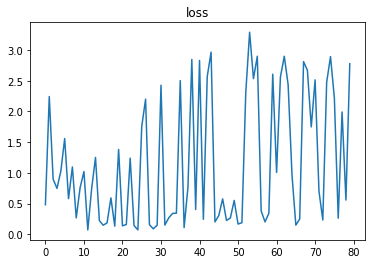

episode: 135, score: 0.0, best score: 9.5, epsilon: 0.93


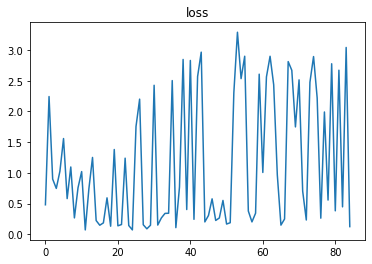

episode: 140, score: 1.0, best score: 9.5, epsilon: 0.93


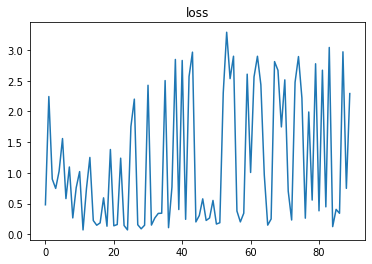

episode: 145, score: 0.0, best score: 9.5, epsilon: 0.93


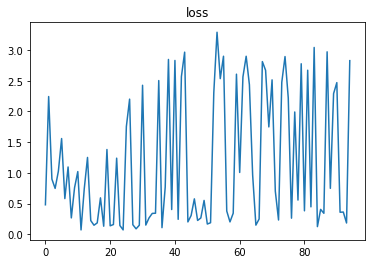

episode: 150, score: 1.0, best score: 9.5, epsilon: 0.93


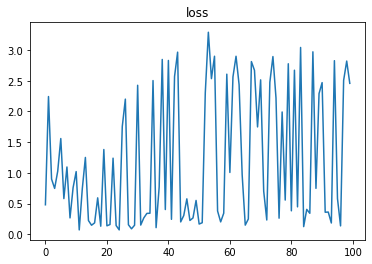

episode: 155, score: 0.0, best score: 9.5, epsilon: 0.92


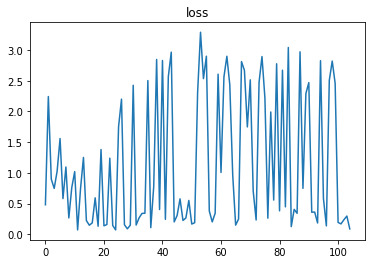

episode: 160, score: 9.5, best score: 9.5, epsilon: 0.92


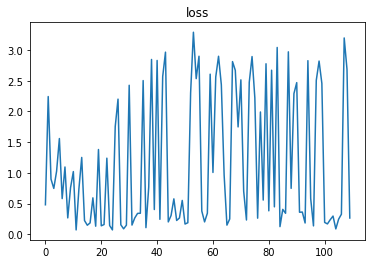

episode: 165, score: 1.0, best score: 9.5, epsilon: 0.92


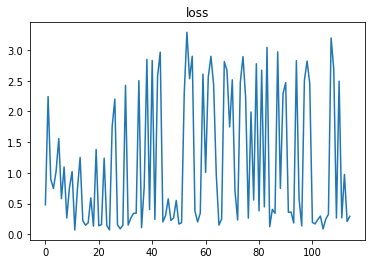

episode: 170, score: 4.5, best score: 9.5, epsilon: 0.92


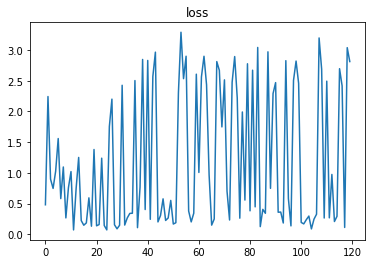

episode: 175, score: 5.0, best score: 9.5, epsilon: 0.91


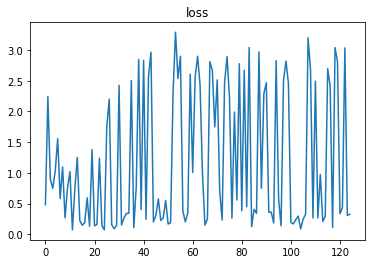

episode: 180, score: 1.0, best score: 9.5, epsilon: 0.91


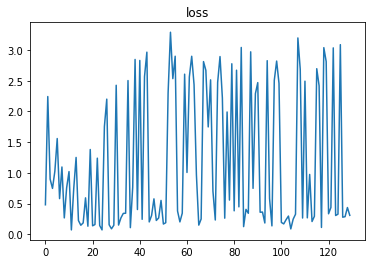

episode: 185, score: 1.0, best score: 9.5, epsilon: 0.91


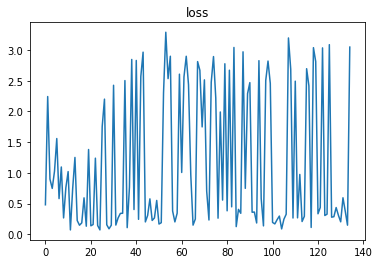

episode: 190, score: 1.0, best score: 9.5, epsilon: 0.91


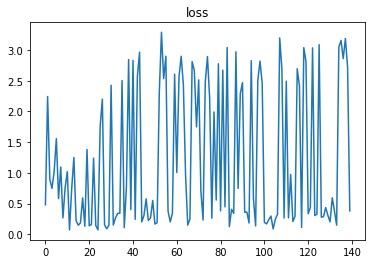

episode: 195, score: 3.5, best score: 9.5, epsilon: 0.90
marking, episode: 200, score: 1.0, mean_score: 1.70, std_score: 2.12


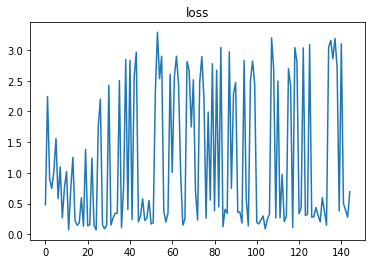

episode: 200, score: 1.0, best score: 9.5, epsilon: 0.90


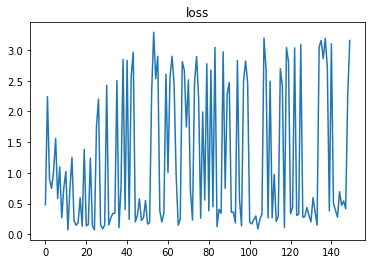

episode: 205, score: 2.0, best score: 9.5, epsilon: 0.90


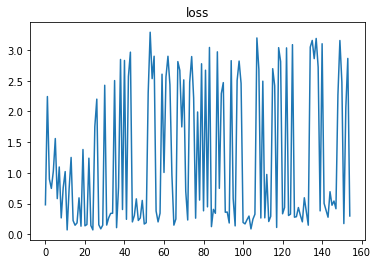

episode: 210, score: 1.0, best score: 9.5, epsilon: 0.90


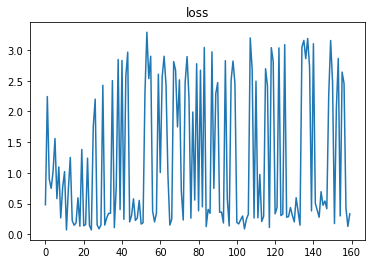

episode: 215, score: 3.5, best score: 9.5, epsilon: 0.89


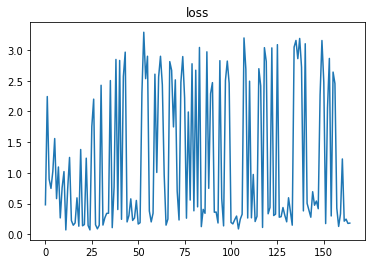

episode: 220, score: 0.0, best score: 9.5, epsilon: 0.89


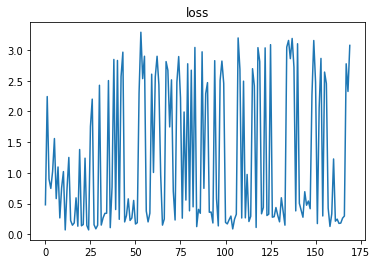

episode: 225, score: 1.0, best score: 9.5, epsilon: 0.89


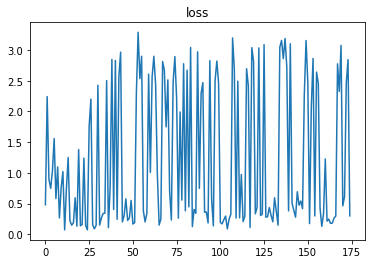

episode: 230, score: 0.0, best score: 9.5, epsilon: 0.89


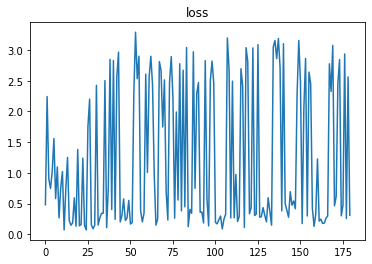

episode: 235, score: 4.0, best score: 9.5, epsilon: 0.88


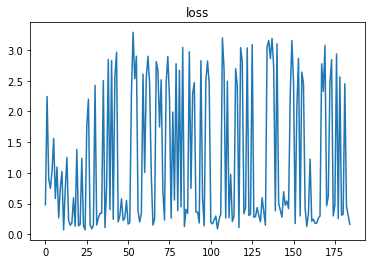

episode: 240, score: 0.0, best score: 9.5, epsilon: 0.88


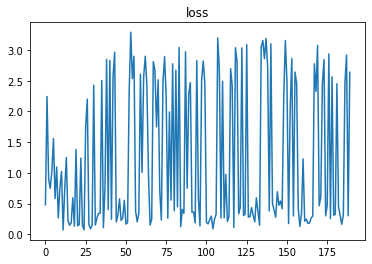

episode: 245, score: 1.0, best score: 9.5, epsilon: 0.88


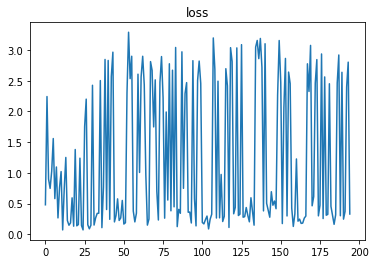

episode: 250, score: 4.5, best score: 9.5, epsilon: 0.88


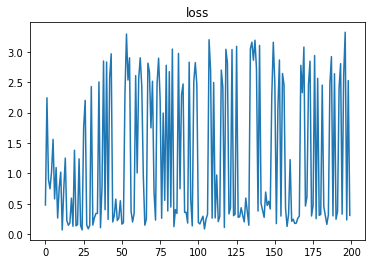

episode: 255, score: 2.5, best score: 9.5, epsilon: 0.87


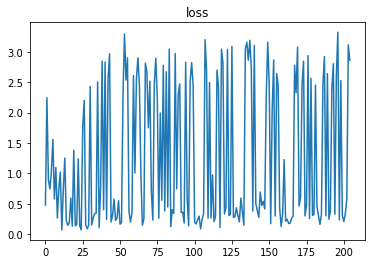

episode: 260, score: 0.0, best score: 9.5, epsilon: 0.87


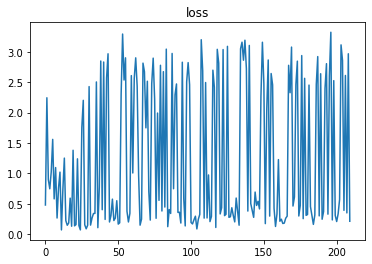

episode: 265, score: 2.5, best score: 9.5, epsilon: 0.87


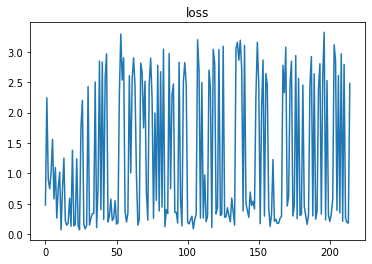

episode: 270, score: 7.0, best score: 9.5, epsilon: 0.86


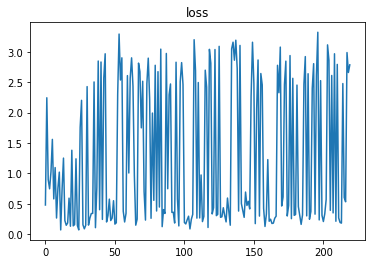

episode: 275, score: 1.0, best score: 9.5, epsilon: 0.86


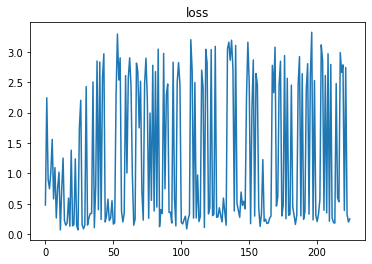

episode: 280, score: 5.5, best score: 9.5, epsilon: 0.86


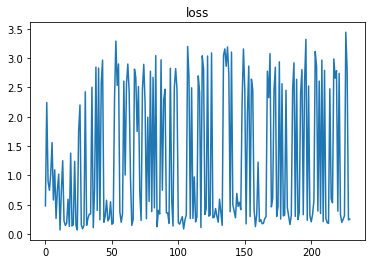

episode: 285, score: 1.0, best score: 9.5, epsilon: 0.86


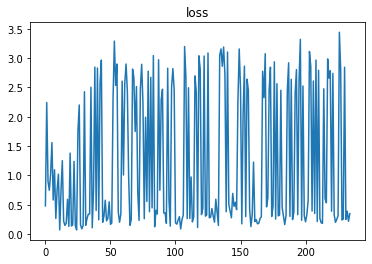

episode: 290, score: 3.5, best score: 9.5, epsilon: 0.85


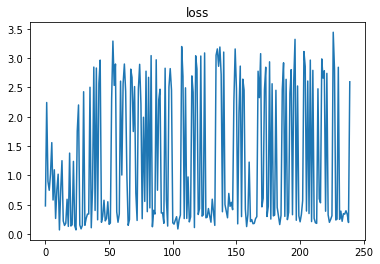

episode: 295, score: 7.5, best score: 9.5, epsilon: 0.85
marking, episode: 300, score: 0.0, mean_score: 2.09, std_score: 2.10


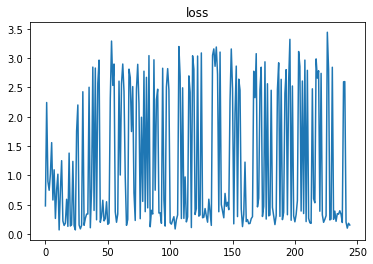

episode: 300, score: 0.0, best score: 9.5, epsilon: 0.85


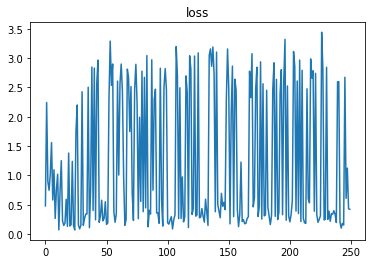

episode: 305, score: 0.0, best score: 9.5, epsilon: 0.85


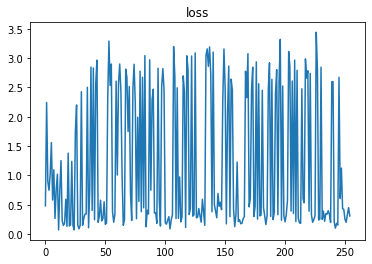

episode: 310, score: 0.0, best score: 9.5, epsilon: 0.84


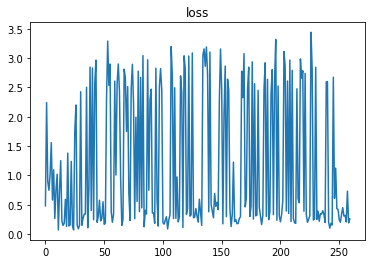

episode: 315, score: 0.0, best score: 9.5, epsilon: 0.84


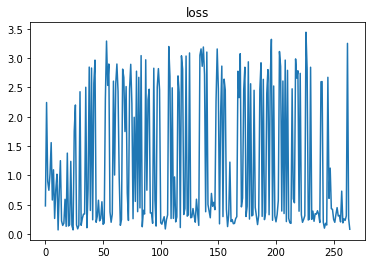

episode: 320, score: 1.0, best score: 9.5, epsilon: 0.84


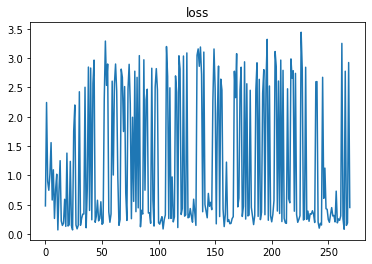

episode: 325, score: 2.5, best score: 9.5, epsilon: 0.84


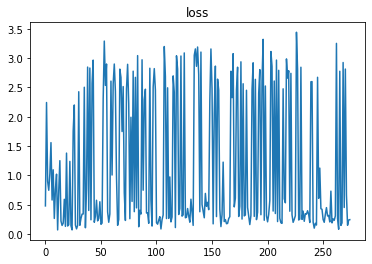

episode: 330, score: 0.0, best score: 9.5, epsilon: 0.83


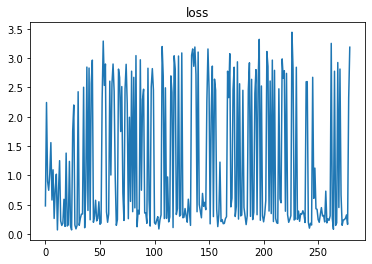

episode: 335, score: 5.0, best score: 9.5, epsilon: 0.83


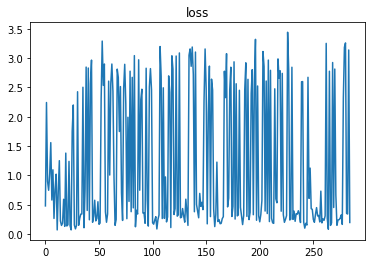

episode: 340, score: 0.0, best score: 9.5, epsilon: 0.83


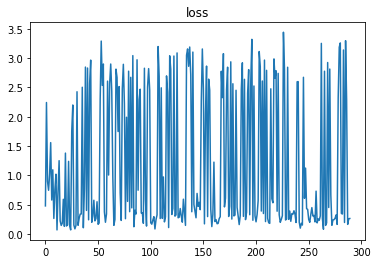

episode: 345, score: 0.0, best score: 9.5, epsilon: 0.83


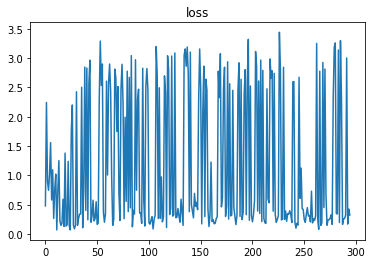

episode: 350, score: 7.0, best score: 9.5, epsilon: 0.82


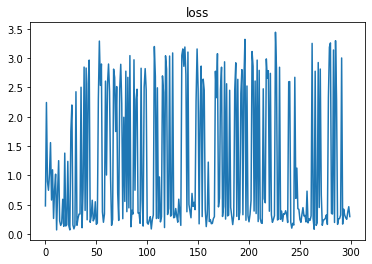

episode: 355, score: 3.5, best score: 9.5, epsilon: 0.82


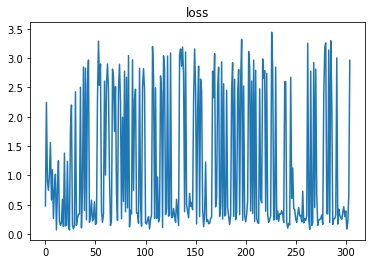

episode: 360, score: 2.5, best score: 9.5, epsilon: 0.82


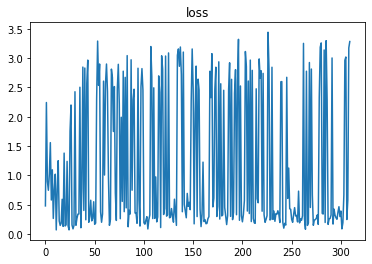

episode: 365, score: 1.0, best score: 9.5, epsilon: 0.82


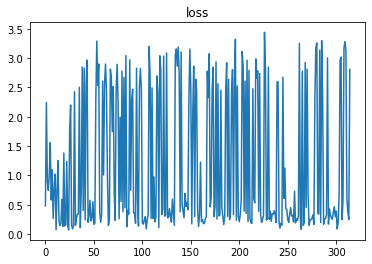

episode: 370, score: 0.0, best score: 9.5, epsilon: 0.81


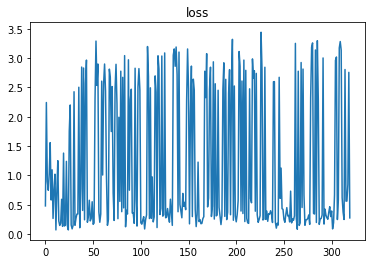

episode: 375, score: 1.0, best score: 9.5, epsilon: 0.81


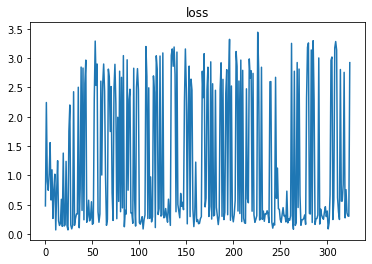

episode: 380, score: 2.5, best score: 9.5, epsilon: 0.81


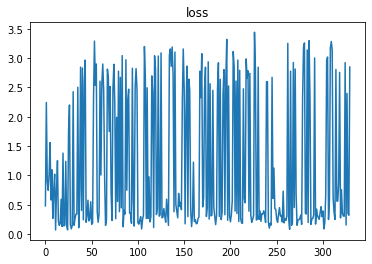

episode: 385, score: 1.0, best score: 9.5, epsilon: 0.81


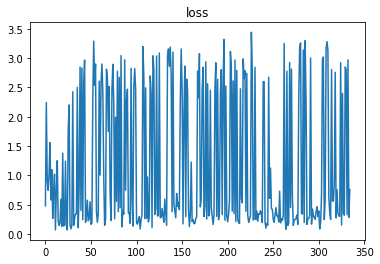

episode: 390, score: 1.0, best score: 9.5, epsilon: 0.80


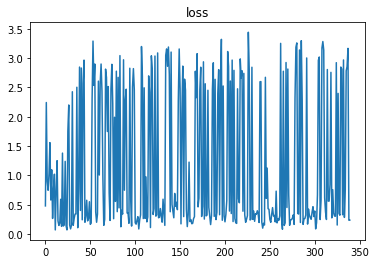

episode: 395, score: 0.0, best score: 9.5, epsilon: 0.80
marking, episode: 400, score: 2.5, mean_score: 2.21, std_score: 2.19


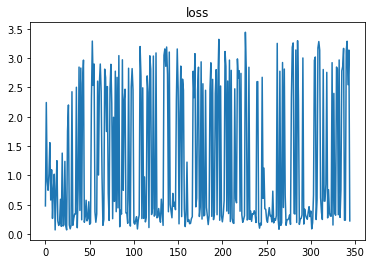

episode: 400, score: 2.5, best score: 9.5, epsilon: 0.80


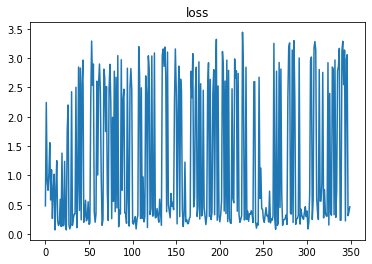

episode: 405, score: 2.5, best score: 9.5, epsilon: 0.80


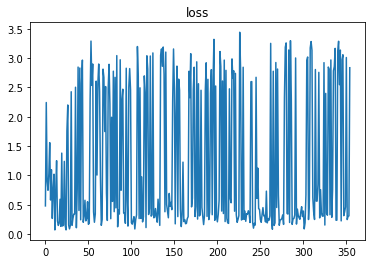

episode: 410, score: 4.5, best score: 9.5, epsilon: 0.79


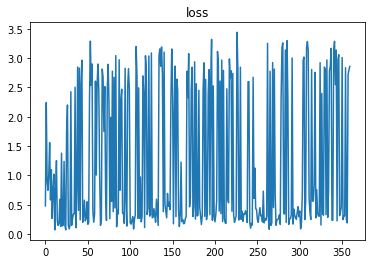

episode: 415, score: 0.0, best score: 9.5, epsilon: 0.79


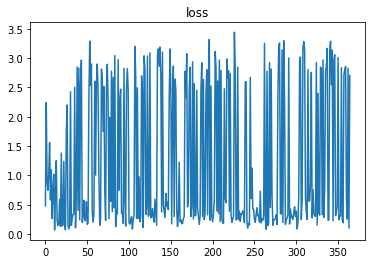

episode: 420, score: 1.0, best score: 9.5, epsilon: 0.79


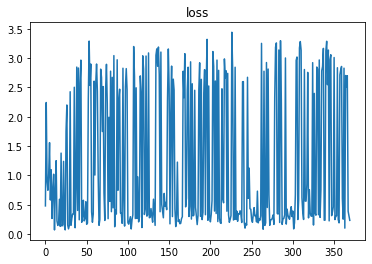

episode: 425, score: 2.5, best score: 9.5, epsilon: 0.79


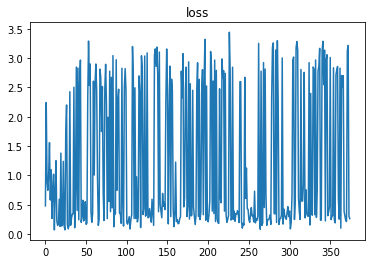

episode: 430, score: 2.5, best score: 9.5, epsilon: 0.79


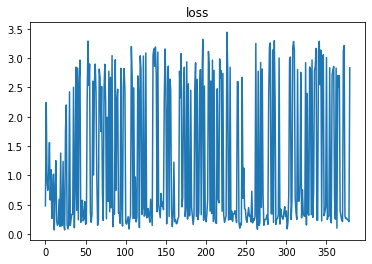

episode: 435, score: 0.0, best score: 9.5, epsilon: 0.78


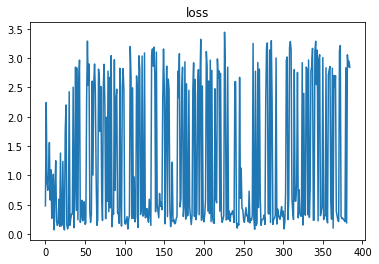

episode: 440, score: 2.5, best score: 9.5, epsilon: 0.78


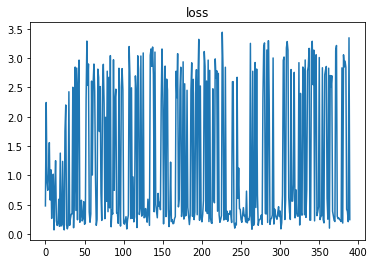

episode: 445, score: 2.5, best score: 9.5, epsilon: 0.78


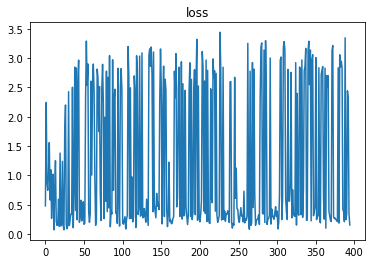

episode: 450, score: 0.0, best score: 9.5, epsilon: 0.78


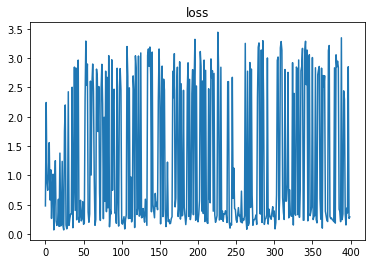

episode: 455, score: 2.5, best score: 9.5, epsilon: 0.77


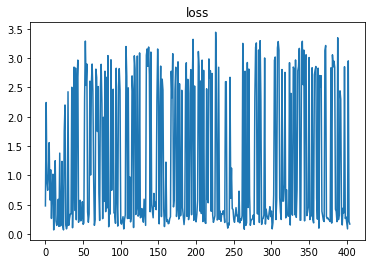

episode: 460, score: 2.5, best score: 9.5, epsilon: 0.77


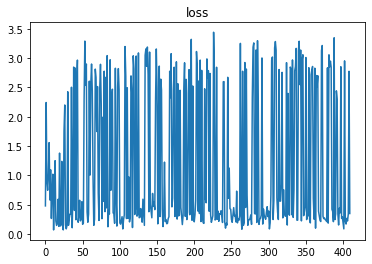

episode: 465, score: 1.0, best score: 9.5, epsilon: 0.77


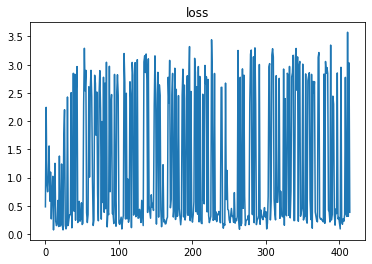

episode: 470, score: 6.0, best score: 9.5, epsilon: 0.77


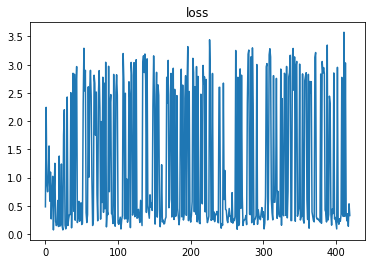

episode: 475, score: 6.0, best score: 9.5, epsilon: 0.76


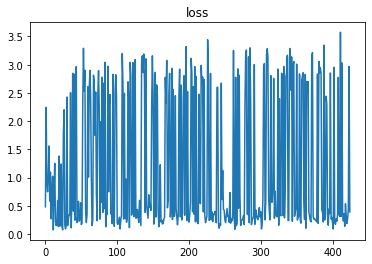

episode: 480, score: 0.0, best score: 9.5, epsilon: 0.76


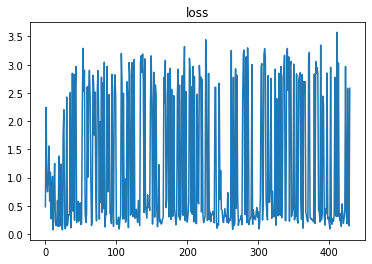

episode: 485, score: 0.0, best score: 9.5, epsilon: 0.76


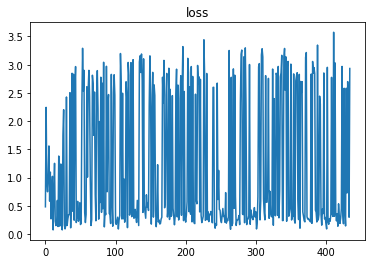

episode: 490, score: 5.0, best score: 9.5, epsilon: 0.76


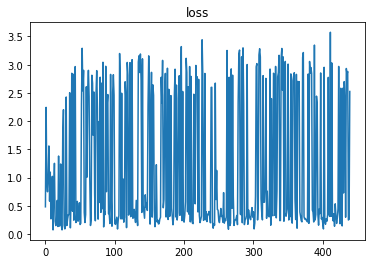

episode: 495, score: 2.0, best score: 9.5, epsilon: 0.75
marking, episode: 500, score: 0.0, mean_score: 2.35, std_score: 2.49


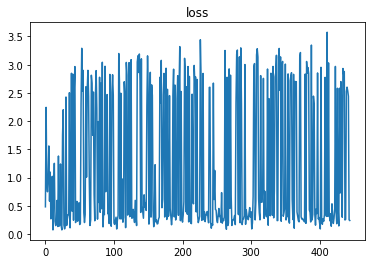

episode: 500, score: 0.0, best score: 9.5, epsilon: 0.75


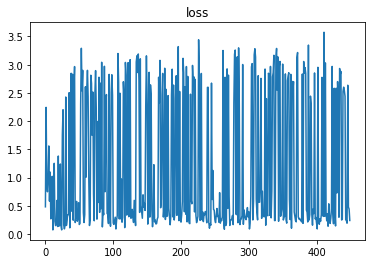

episode: 505, score: 0.0, best score: 9.5, epsilon: 0.75


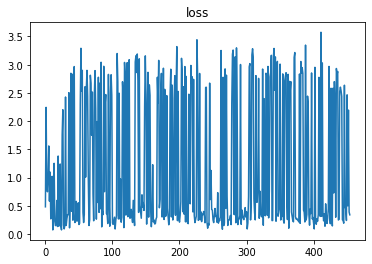

episode: 510, score: 5.0, best score: 22.0, epsilon: 0.74


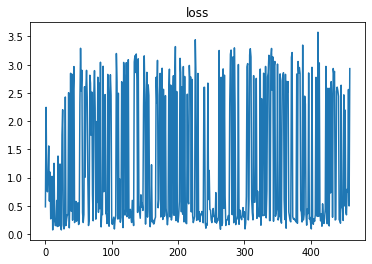

episode: 515, score: 0.0, best score: 22.0, epsilon: 0.74


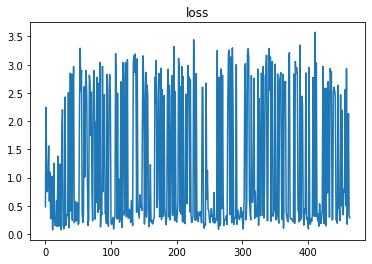

episode: 520, score: 1.0, best score: 22.0, epsilon: 0.74


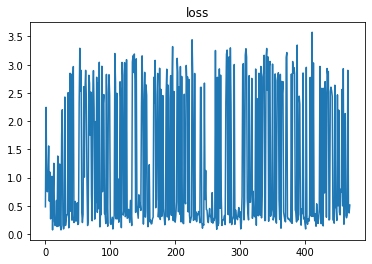

episode: 525, score: 2.5, best score: 22.0, epsilon: 0.74


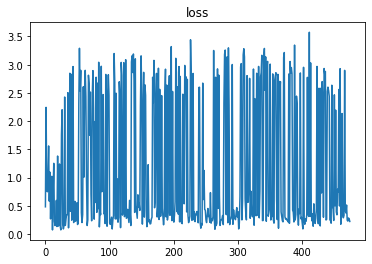

episode: 530, score: 2.5, best score: 22.0, epsilon: 0.73


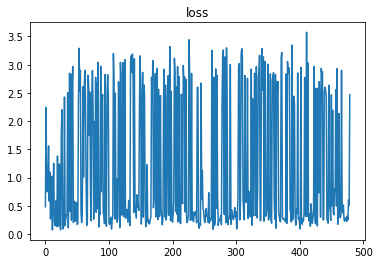

episode: 535, score: 2.5, best score: 22.0, epsilon: 0.73


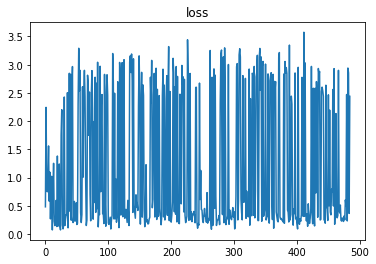

episode: 540, score: 1.0, best score: 22.0, epsilon: 0.73


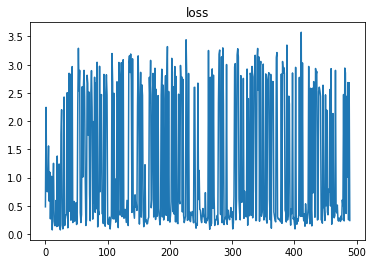

episode: 545, score: 3.5, best score: 22.0, epsilon: 0.73


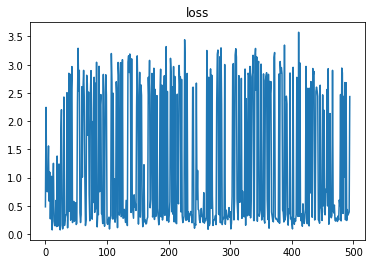

episode: 550, score: 6.0, best score: 22.0, epsilon: 0.72


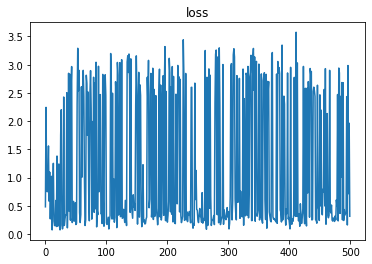

episode: 555, score: 4.5, best score: 22.0, epsilon: 0.72


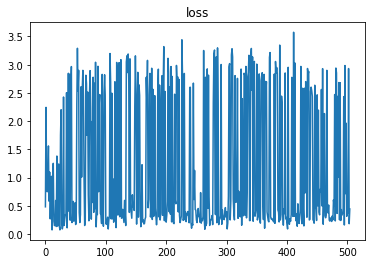

episode: 560, score: 1.0, best score: 22.0, epsilon: 0.72


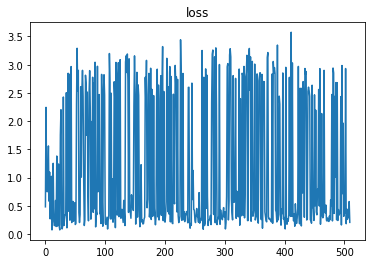

episode: 565, score: 4.5, best score: 22.0, epsilon: 0.72


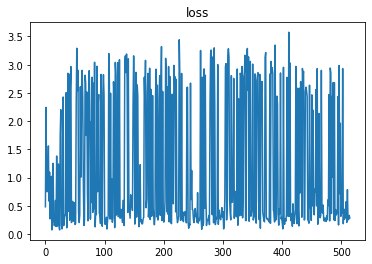

episode: 570, score: 0.0, best score: 22.0, epsilon: 0.71


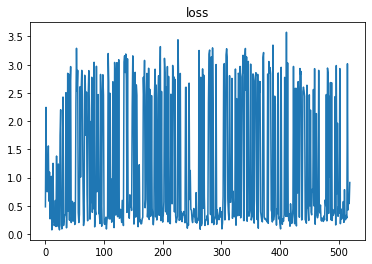

episode: 575, score: 1.0, best score: 22.0, epsilon: 0.71


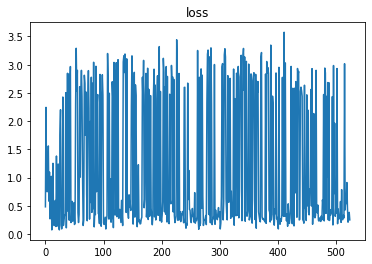

episode: 580, score: 7.0, best score: 22.0, epsilon: 0.71


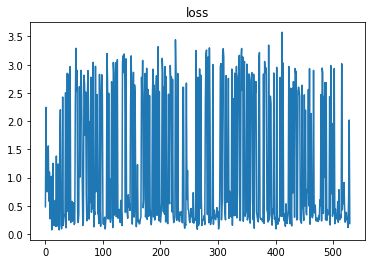

episode: 585, score: 0.0, best score: 22.0, epsilon: 0.71


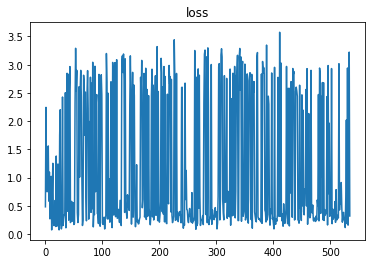

episode: 590, score: 2.0, best score: 22.0, epsilon: 0.71


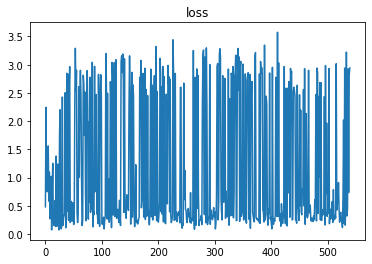

episode: 595, score: 0.0, best score: 22.0, epsilon: 0.70
marking, episode: 600, score: 0.0, mean_score: 2.32, std_score: 2.97


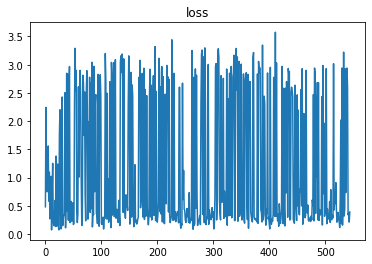

episode: 600, score: 0.0, best score: 22.0, epsilon: 0.70


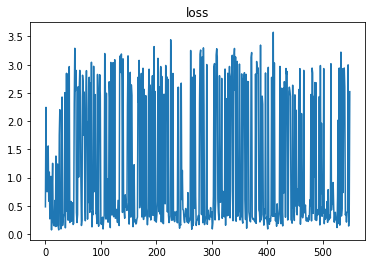

episode: 605, score: 0.0, best score: 22.0, epsilon: 0.70


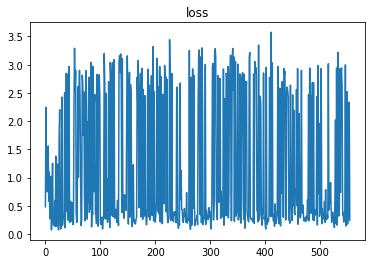

episode: 610, score: 1.0, best score: 22.0, epsilon: 0.70


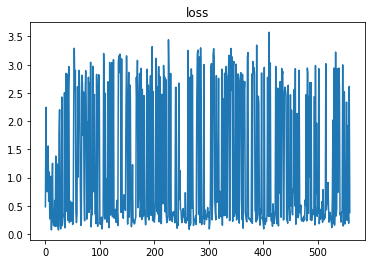

episode: 615, score: 3.5, best score: 22.0, epsilon: 0.69


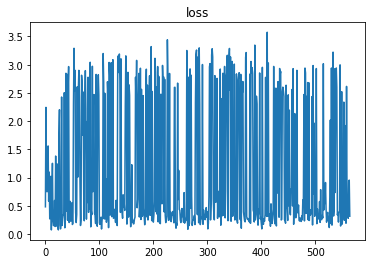

episode: 620, score: 1.0, best score: 22.0, epsilon: 0.69


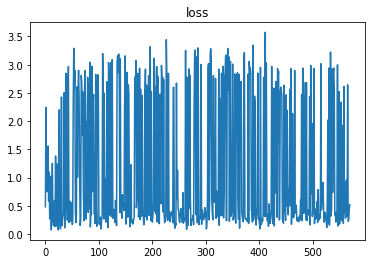

episode: 625, score: 0.0, best score: 22.0, epsilon: 0.69


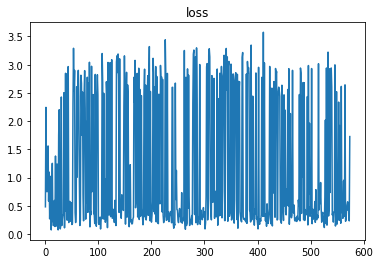

episode: 630, score: 0.0, best score: 22.0, epsilon: 0.69


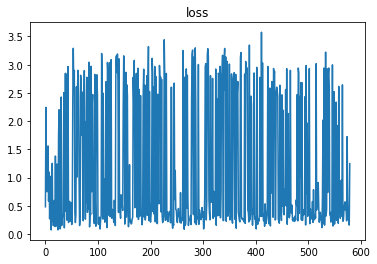

episode: 635, score: 0.0, best score: 22.0, epsilon: 0.68


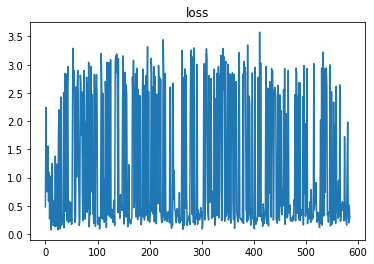

episode: 640, score: 5.5, best score: 22.0, epsilon: 0.68


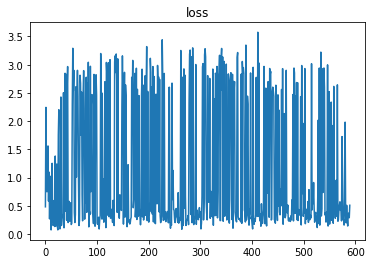

episode: 645, score: 2.0, best score: 22.0, epsilon: 0.68


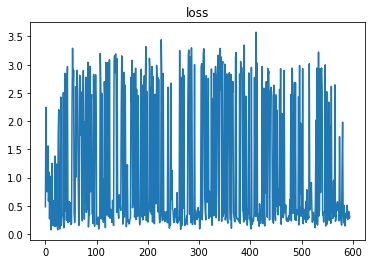

episode: 650, score: 2.0, best score: 22.0, epsilon: 0.68


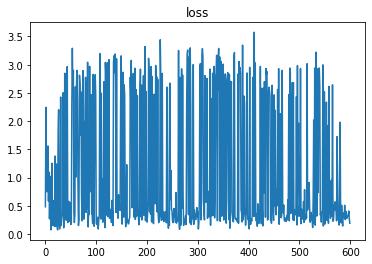

episode: 655, score: 2.0, best score: 22.0, epsilon: 0.67


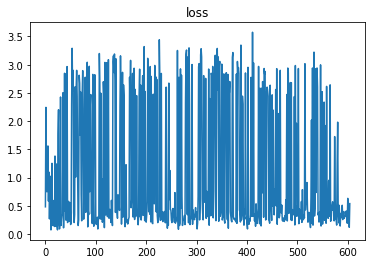

episode: 660, score: 0.0, best score: 22.0, epsilon: 0.67


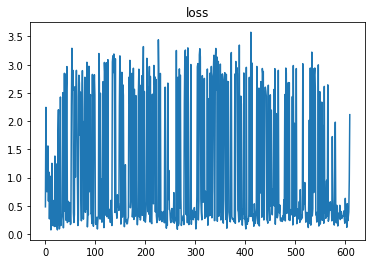

episode: 665, score: 2.0, best score: 22.0, epsilon: 0.67


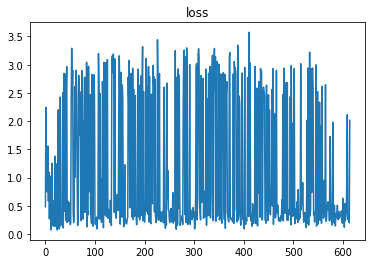

episode: 670, score: 0.0, best score: 22.0, epsilon: 0.67


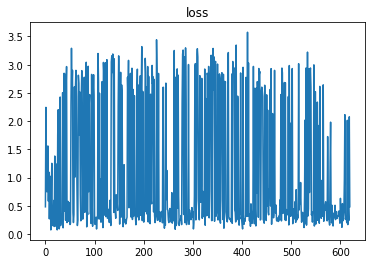

episode: 675, score: 6.0, best score: 22.0, epsilon: 0.66


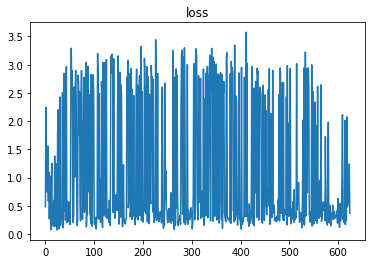

episode: 680, score: 0.0, best score: 22.0, epsilon: 0.66


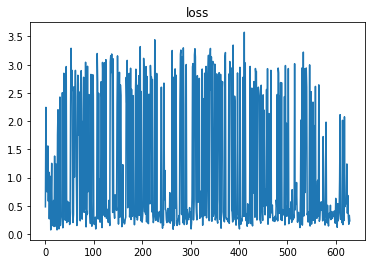

episode: 685, score: 6.0, best score: 22.0, epsilon: 0.66


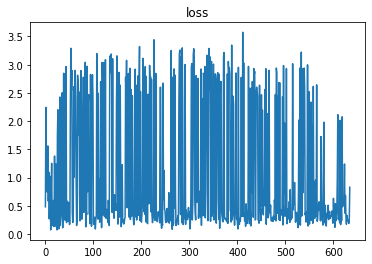

episode: 690, score: 0.0, best score: 22.0, epsilon: 0.66


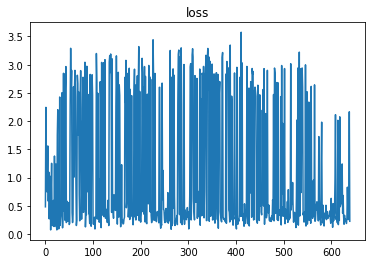

episode: 695, score: 3.5, best score: 22.0, epsilon: 0.65
marking, episode: 700, score: 6.0, mean_score: 1.86, std_score: 1.95


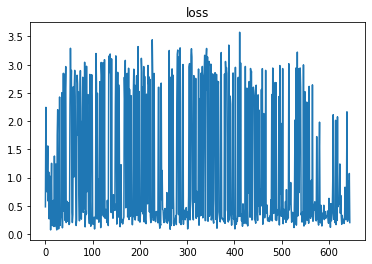

episode: 700, score: 6.0, best score: 22.0, epsilon: 0.65


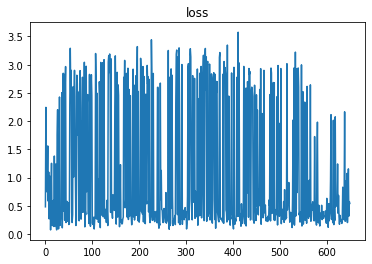

episode: 705, score: 2.5, best score: 22.0, epsilon: 0.65


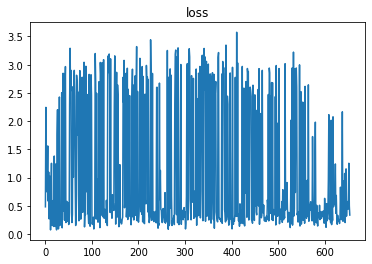

episode: 710, score: 5.5, best score: 22.0, epsilon: 0.65


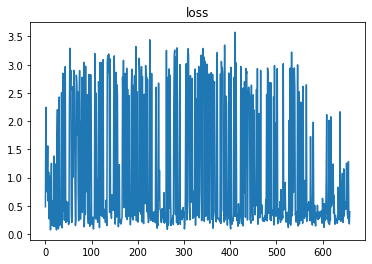

episode: 715, score: 2.5, best score: 22.0, epsilon: 0.64


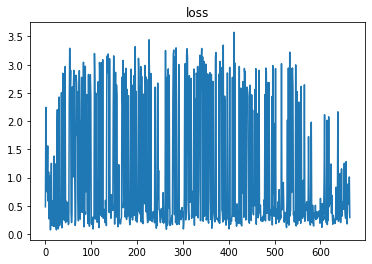

episode: 720, score: 0.0, best score: 22.0, epsilon: 0.64


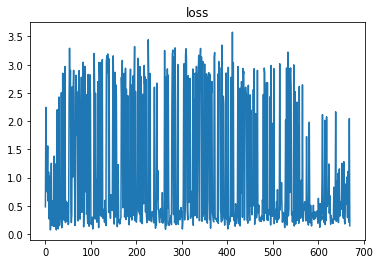

episode: 725, score: 0.0, best score: 22.0, epsilon: 0.64


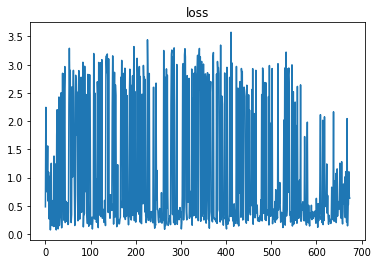

episode: 730, score: 0.0, best score: 22.0, epsilon: 0.64


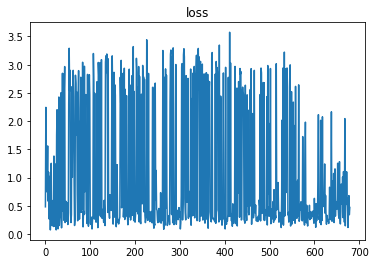

episode: 735, score: 0.0, best score: 22.0, epsilon: 0.63


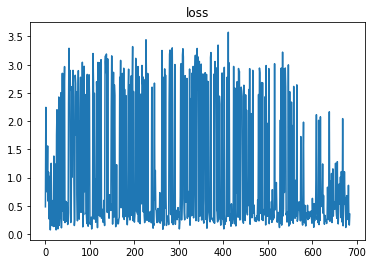

episode: 740, score: 5.0, best score: 22.0, epsilon: 0.63


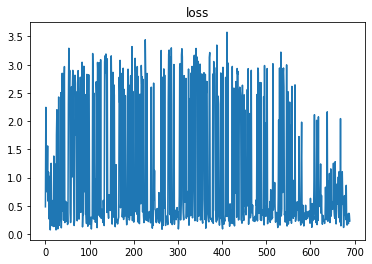

episode: 745, score: 1.0, best score: 22.0, epsilon: 0.63


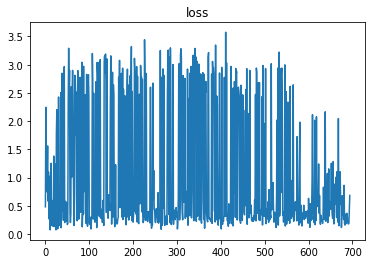

episode: 750, score: 5.0, best score: 22.0, epsilon: 0.62


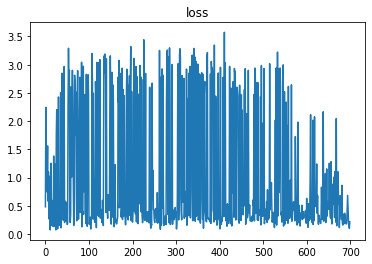

episode: 755, score: 5.0, best score: 22.0, epsilon: 0.62


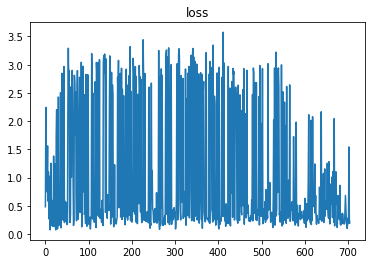

episode: 760, score: 6.0, best score: 22.0, epsilon: 0.62


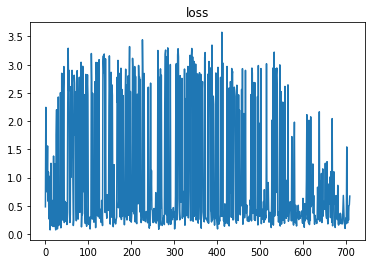

episode: 765, score: 9.5, best score: 22.0, epsilon: 0.62


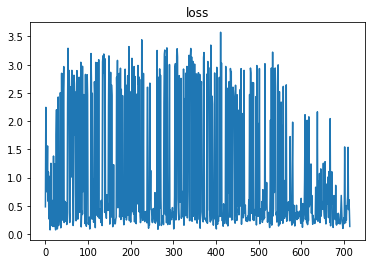

episode: 770, score: 3.5, best score: 22.0, epsilon: 0.61


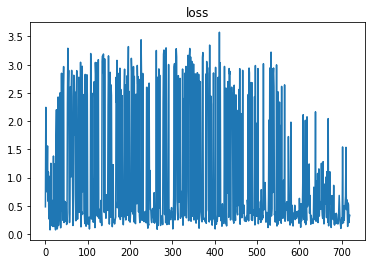

episode: 775, score: 2.5, best score: 22.0, epsilon: 0.61


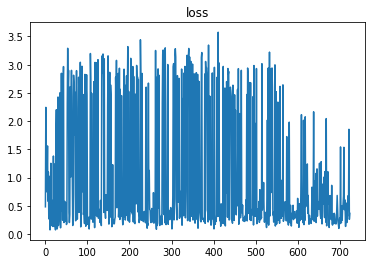

episode: 780, score: 0.0, best score: 22.0, epsilon: 0.61


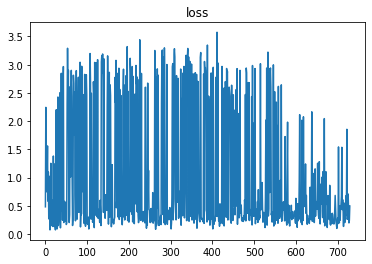

episode: 785, score: 4.5, best score: 22.0, epsilon: 0.61


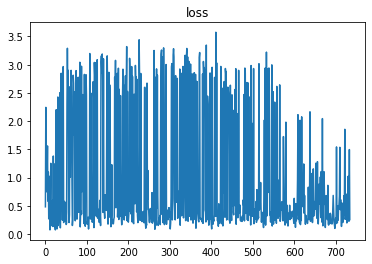

episode: 790, score: 1.0, best score: 22.0, epsilon: 0.60


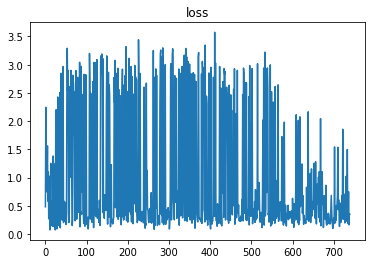

episode: 795, score: 2.5, best score: 22.0, epsilon: 0.60
marking, episode: 800, score: 2.5, mean_score: 2.25, std_score: 2.24


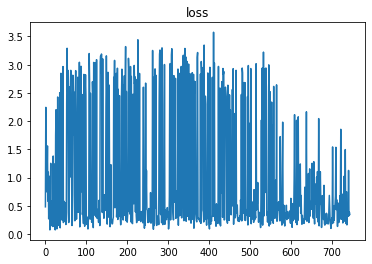

episode: 800, score: 2.5, best score: 22.0, epsilon: 0.60


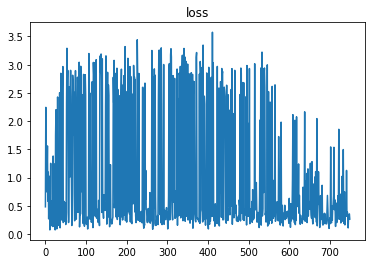

episode: 805, score: 0.0, best score: 22.0, epsilon: 0.60


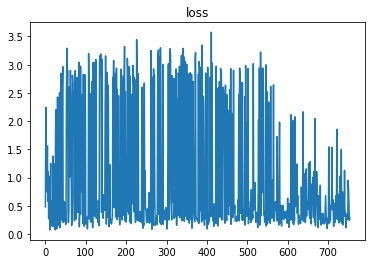

episode: 810, score: 4.5, best score: 22.0, epsilon: 0.59


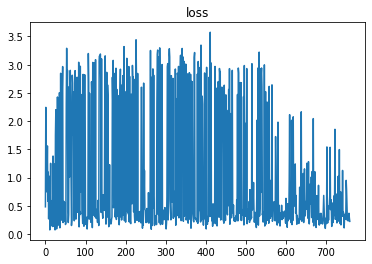

episode: 815, score: 1.0, best score: 22.0, epsilon: 0.59


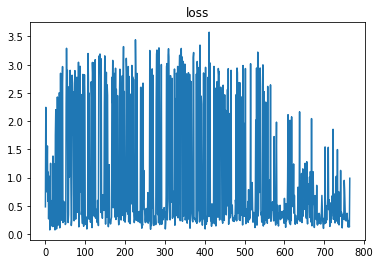

episode: 820, score: 7.0, best score: 22.0, epsilon: 0.59


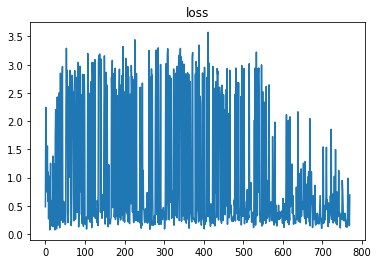

episode: 825, score: 2.0, best score: 22.0, epsilon: 0.59


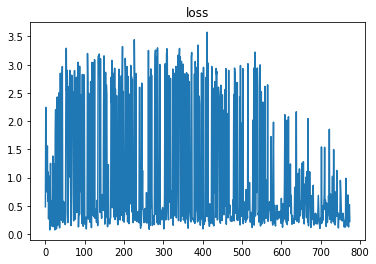

episode: 830, score: 1.0, best score: 22.0, epsilon: 0.58


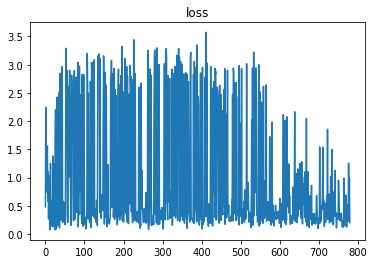

episode: 835, score: 0.0, best score: 22.0, epsilon: 0.58


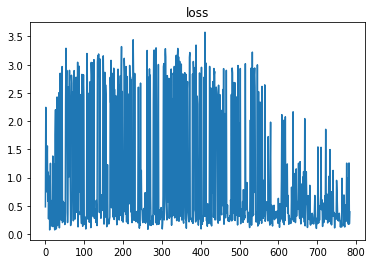

episode: 840, score: 0.0, best score: 22.0, epsilon: 0.58


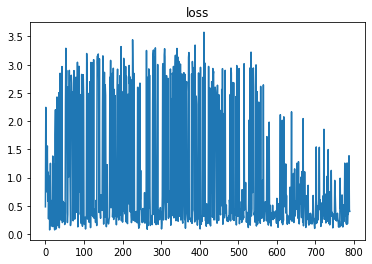

episode: 845, score: 0.0, best score: 22.0, epsilon: 0.58


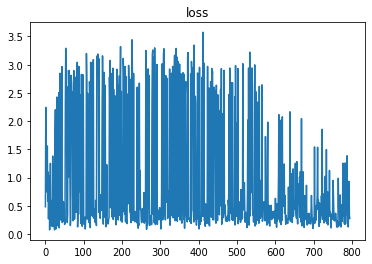

episode: 850, score: 1.0, best score: 22.0, epsilon: 0.57


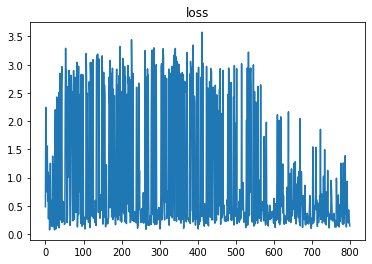

episode: 855, score: 7.5, best score: 22.0, epsilon: 0.57


In [ ]:
# setup the Gravitar ram environment, and record a video every 50 episodes. You can use the non-ram version here if you prefer
env = gym.make(env_name)
env = gym.wrappers.FrameStack(gym.wrappers.Monitor(gym.wrappers.AtariPreprocessing(env, frame_skip=1), "./video", video_callable=lambda episode_id: (episode_id%video_every)==0,force=True), 4)

# reproducible environment and action spaces, do not change lines 6-11 here (tools > settings > editor > show line numbers)
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# Init networks, mem and optim
q = QNetwork().to(dev)
#q.load_state_dict(torch.load(os.path.join("/content", "drive", "My Drive", 'params')))
q_target = QNetwork().to(dev)
q_target.load_state_dict(q.state_dict())
memory = RecPriorityReplayBuffer(buffer_limit)
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

losses = []
score    = 0.0
marking  = []
best_score = -1e5

seq_buf = [] # Stores sequences 
step_buf = deque(maxlen=n_steps) # Store a queue of states, once buffer length is reached, use to calculate return (misses end of seq as these are score based games)
for n_episode in range(int(10000)):
  epsilon = max(0.02, 1.0 - 0.01*(n_episode/20)) # linear annealing from 8% to 1%
  s = env.reset()
  done = False
  score = 0.0
  a = 0
  q.zeroMem(1)
  while True:
    a = q.sample_action(torch.from_numpy(np.array(s)).float().unsqueeze(0).to(dev), epsilon, torch.tensor([[a]], device=dev)) # Feed in last action for R2D2
    s_prime, r, done, info = env.step(a)
    r *= rew_scale
    done_mask = 0.0 if done else 1.0
    
    step_buf.append((s, a, r, done))
    if len(step_buf) >= n_steps:
      ret = sum([gam_vals[x] * step_buf[x][2] for x in range(n_steps)]) # sum up returns
      seq_buf.append((step_buf[0][0], step_buf[0][1], ret, done_mask)) #/100 REMEMBER THIS

    if len(seq_buf) == seq_len:
      memory.put(seq_buf)
      seq_buf = seq_buf[seq_ovlp:] 

    s = s_prime
    score += r

    if done:
        break

  step_buf.clear()
  seq_buf = []

  best_score = max(best_score, score)
  if memory.size() >= 1024: # Train after every episode
    train(q, q_target, memory, optimizer, losses)

  # do not change lines 44-48 here, they are for marking the submission log
  marking.append(score)
  if n_episode % 100 == 0:
    print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
        n_episode, score, np.array(marking).mean(), np.array(marking).std()))
    marking = []
    #torch.save(q.state_dict(), os.path.join("/content", "drive", "My Drive", 'params_rl_a'))

  # you can change this part, and print any data you like (so long as it doesn't start with "marking")
  if n_episode%print_every==0 and n_episode!=0:
    #clear_output(True)
    q_target.load_state_dict(q.state_dict()) # This is the magic line
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    print("episode: {}, score: {:.1f}, best score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, best_score, epsilon))

In [ ]:
seq, _, _ = memory.sample(batch_size)
print(memory.size())

In [ ]:
for t in seq:
  clear_output(True)
  print(t[2][10])
  #f, axarr = plt.subplots(2,4) 
  """axarr[0, 0].imshow(t[0][0].cpu(), cmap='gray')
  axarr[0, 1].imshow(t[0][1].cpu(), cmap='gray')
  axarr[0, 2].imshow(t[0][2].cpu(), cmap='gray')
  axarr[0, 3].imshow(s[0][3].cpu(), cmap='gray')"""
  plt.imshow(t[0][10][0].cpu(), cmap='gray')
  plt.pause(0.1)

In [ ]:
f, axarr = plt.subplots(2,4) 
axarr[0, 0].imshow(s[0][0].cpu(), cmap='gray')
axarr[0, 1].imshow(s[0][1].cpu(), cmap='gray')
axarr[0, 2].imshow(s[0][2].cpu(), cmap='gray')
axarr[0, 3].imshow(s[0][3].cpu(), cmap='gray')
axarr[1, 0].imshow(s_prime[0][0].cpu(), cmap='gray')
axarr[1, 1].imshow(s_prime[0][1].cpu(), cmap='gray')
axarr[1, 2].imshow(s_prime[0][2].cpu(), cmap='gray')
axarr[1, 3].imshow(s_prime[0][3].cpu(), cmap='gray')
print(a[0], r[0])